# CNN Cancer Detection
*A deep learning project* 🦾 

### Overview

In today's world we are fortunate enough to have advanced technology which allows the medical field to provide better patient care. Cancer is a highly researched area because there are so many people who suffer and/or die of cancerous disease. This study aims to improve cancer detection in lymph nodes by using computer vision machine learning technqiues. We will examine the data given in this competition to get a better understanding of it. Then, we will run multiple convolutional neural network models with the intent to be able to classify cancerous (1) and non-cancerous cells (0). With improved and faster cancer detection, patients will be able to recieve life-saving treatments faster. This the first step in those peoples cancer survival story. This notebook covers the thought process as to how to create simple CNN models. We will create two models, one without hyperparameter tuning, and one with tuning. Finally, we will suggest ways to improve the models in future studies.

Layout for this notebook was given in assignment brief and is as follows: 


1. Brief Description of the Problem and Data


2. Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data


3. Describe Model Architecture 


4. Results and Analysis


5. Conclusion


In [1]:
#import libraries

#general libraries 
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

# work with images
from skimage.transform import rotate
from skimage import io
import cv2 as cv

# model development
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
tf.__version__

In [3]:
#get files
test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

In [4]:
# declare constants for reproduciblity
RANDOM_STATE = 49

# 1. Brief Description of the Problem and Data

This data contains thousands of small images where the 96x96 pixel images with 3 channels, each with an identifying label and id. We have two datasets, a training and testing set already split for us. The training set contains 220,025 unique images and the test set contains about 57,500. To use these images in a machine learning model, we are also given an identifying dataframe with two columns: 'id' which is the unique image ID correpsonding to the training directory, and 'label' which tells us the classification category. Each label is either a 0 or 1, depending whether the image is non-cancerous (0) or cancerous (1). In the competition description, we find that if at least one pixel of an image is identified as cancerous then the whole image is therefore marked with a 1, otherwise it is 0. It is important to note that we do not have any missing values in this data which will make preprocessing more efficient.

In [5]:
# have a look at the format of the data
train_data.head()

In [6]:
# take a look at the data further
train_data.describe()

In [7]:
# check information, data types, and for missing data
train_data.info()

# 2. Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data

First, we will visualize the data. Then we will clean/preprocess the data. 

We can see in the histogram and pie chart below that we have 59.5% of the labels are 0 (non-cancerous images) and 40.5% are labeled 1 (cancerous images). We were told in the competition description that the data is 50/50 split between cancerous and non-cancerous images however, from what we are finding here, we have a split which is closer to 40/60. This means that our data is unbalanced, however it is not severely unbalanced either (compared to a split such as 30/70 or even 10/90). We also have thousands of images to train with. For this reason, we can assume we will be able to create a sufficiently performing model which identifies cancerous images. 

In [8]:
#create histogram
print(pd.DataFrame(data={'Label Counts': train_data['label'].value_counts()}))
sns.countplot(x=train_data['label'], palette='colorblind').set(title='Label Counts Histogram');

In [9]:
#create pie chart
fig = px.pie(train_data, 
             values = train_data['label'].value_counts().values, 
             names = train_data['label'].unique())
fig.update_layout(
    title={
        'text': "Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

Below we can see some example images from the training data. As someone who is not familiar at looking at cancer cells and images, it would be very challenging for me to classify these. However, we mitigate this by putting the correct label for each image is below it. Additionally, we were told that each image has the (potentially) cancerous cells centered in each 32x32 pixel image, so we have drawn a box around this area as a focal point. 

In [10]:
#visualize a few images
fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i, axis in enumerate(ax.flat):
    file = str(train_path + train_data.id[i] + '.tif')
    image = io.imread(file)
    axis.imshow(image)
    box = patches.Rectangle((32,32),32,32, linewidth=2, edgecolor='r',facecolor='none', linestyle='-')
    axis.add_patch(box)
    axis.set(xticks=[], yticks=[], xlabel = train_data.label[i]);
    #cv2.waitKey(0)

**Preprocessing Techniques**


When working with training data, first we want to handle any missing data. From the source description and our findings above, we can see that we have no missing data in the training set. Next, we are told that the part of the image which is going to be of interest is the center pixels (red box above). Right now the images are 96x96x3 and we know that the "3" is the RGB channel. For now, we will leave this as well. Lastly, there are many augmentations you can perform on images to produce better results and facilitate model learning, but to start we will not touch these either for simplicity. 

What we will do with the image data is **shuffle** the data so that the model doesn't learn based on the image ordering/pattern of input, which could potentially have consequences in the model training. We will also **split** the data into training and validation set to improve model development. During training we will also **normalize** the pixels by dividing by 255.0, which should help data processing and model training.

# 3. Describe Model Architecture 

For this model we will be using Keras' library to run a convolutional neural network (CNN). The first model we will run without tuning any hyperparameters within the model and use that as our baseline. Then, we will run a second model, tuning hyperparameters such as learning rate, batch normalization, regularization, filter size, stride, activation layers, etc. 

Our CNN model will have a network such that there are two convolutional layers then a MaxPool layer, and we repeat this *n* number of times. Specifically, we will create a fairly simple model with two (n=2) of these clusters. In other words, our model will be input --> Conv2D --> Conv2D --> MaxPool --> Conv2D --> Conv2D --> MaxPool --> Flatten --> Output with sigmoid activation.

**First model:**
1. Normalize images pre-training (image/255)
2. Output layer activation (sigmoid)

**Second model contains all the first model parameters, but we also add:**
1. Dropout (0.1)
2. Batch Normalization
3. Optimization (Adam)
4. Learning rate (0.0001) 
5. Hidden layer activations (ReLU)

Before we start with the models, let's describe what each of the parameters will do to the model. In both models we will use 1 and 2, numbers 3 to 5 will be used in the second and final models. 
1. **Normalize images** : this will take the pixels and divide each pixel by 255 to normalize the data and have values between 0-1.
2. **Output layer activation** : we will use a sigmoid activation function on the output layer since we are working with binary data
3. **Dropout** : we will set dropout at 0.1 which will randonly select some weights and set them to equal 0 which regularizes the model because it is using a smaller number of weights for each training run. 
4. **Optimization** : we will use adaptive moment estimation (Adam) for optimizing the model which essentially mimics momentum for gradient adn gradient-squared. 
5. **Learning rate**: we will set our learning rate to 0.0001 which will assist in the gradient descent such that as the model learns, the speed of learning decreases so that it is less likely to overstep the (hopefully) global minimum. 
6. **Hidden layer activations**: we will use rectified linear regression (ReLU) as our hidden layer activation function which will help the model to converge better, prevent saturation, and provide less need for computation power. 

In addition, we will use fairly large **batch sizes**, set at 256 to help reduce variance. Finally we wil train our two models with 10 **epochs**. We will use accuracy and the ROC-AUC curve to measure model performance, as well as binary cross-entropy as our loss function.

In [11]:
# set model constants
BATCH_SIZE = 256

In [12]:
# prepare data for training
def append_tif(string):
    return string+".tif"

train_data["id"] = train_data["id"].apply(append_tif)
train_data['label'] = train_data['label'].astype(str)

# randomly shuffle training data
train_data = shuffle(train_data, random_state=RANDOM_STATE)

In [13]:
# modify training data by normalizing it 
# and split data into training and validation sets
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.15)

In [14]:
# generate training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))        # original image = (96, 96) 

In [15]:
# generate validation data
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))       # original image = (96, 96) 

In [16]:
# Setup GPU accelerator - configure Strategy. Assume TPU...if not set default for GPU/CPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

**Start First model building and training**

Here we build our first model. This model is fairly simple with a handful of layers, void of activations except the last layer. The last layer we use a sigmoid activation function since our data is binary (0-1). We can see below how the model is built and how many parameters we will need to train for this model. The next cell below we can see the model training per epoch. 

In [34]:
# set ROC AUC as metric
ROC_1 = tf.keras.metrics.AUC()

# use GPU
with strategy.scope():
    
    #create model
    model_one = Sequential()
    
    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(Conv2D(filters=16, kernel_size=(3,3)))
    model_one.add(MaxPooling2D(pool_size=(2,2)))

    model_one.add(Conv2D(filters=32, kernel_size=(3,3)))
    model_one.add(Conv2D(filters=32, kernel_size=(3,3)))
    model_one.add(AveragePooling2D(pool_size=(2,2)))

    model_one.add(Flatten())
    model_one.add(Dense(1, activation='sigmoid'))
    
    #build model by input size
    model_one.build(input_shape=(BATCH_SIZE, 64, 64, 3))        # original image = (96, 96, 3) 
    
    #compile
    model_one.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_1])
    
#quick look at model
model_one.summary()

In [18]:
EPOCHS = 10

# train the model
history_model_one = model_one.fit_generator(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

Now that we have trained the model, we can take at look at how it did graphically with the training data. Below we can see the accuracy and loss with regards to the validation and training set. We can also see how it did with the ROC AUC per epoch. 

In [20]:
# plot model accuracy per epoch 
plt.plot(history_model_one.history['accuracy'])
plt.plot(history_model_one.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model loss per epoch
plt.plot(history_model_one.history['loss'])
plt.plot(history_model_one.history['val_loss'])
plt.title('Model One Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model ROC per epoch
plt.plot(history_model_one.history['auc'])
plt.plot(history_model_one.history['val_auc'])
plt.title('Model One AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

**Start second model building and training**

Our second model incorporates hyperparameter tuning. We can see we are using ReLU activation functions for hidden layers, dropout between clusters, and batch normalization. In addition, we have added another hidden layer before the flatten and output layers. Lastly, we are using Adam optimizer with a low learning rate. 

In [21]:
# build second model like first but with hyperparameters and optimizer(s)
ROC_2 = tf.keras.metrics.AUC()

with strategy.scope():
    
    #create model
    model_two = Sequential()
    
    model_two.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', ))
    model_two.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model_two.add(MaxPooling2D(pool_size=(2,2)))
    model_two.add(Dropout(0.1))
    
    model_two.add(BatchNormalization())
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(AveragePooling2D(pool_size=(2,2)))
    model_two.add(Dropout(0.1))
    
    model_two.add(BatchNormalization())
    model_two.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model_two.add(Flatten())
    model_two.add(Dense(1, activation='sigmoid'))
    
    #build model by input size
    model_two.build(input_shape=(BATCH_SIZE, 64, 64, 3))       # original image = (96, 96, 3) 
    
    #compile
    adam_optimizer = Adam(learning_rate=0.0001)
    model_two.compile(loss='binary_crossentropy', metrics=['accuracy', ROC_2], optimizer=adam_optimizer)

#quick look at model
model_two.summary()

In [22]:
EPOCHS = 10

# train model
history_model_two = model_two.fit_generator(
                        train_generator,
                        epochs = EPOCHS,
                        validation_data = valid_generator)

In [24]:
# graph loss
plt.plot(history_model_two.history['accuracy'])
plt.plot(history_model_two.history['val_accuracy'])
plt.title('Model Two Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

plt.plot(history_model_two.history['loss'])
plt.plot(history_model_two.history['val_loss'])
plt.title('Model Two Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# plot model ROC per epoch
plt.plot(history_model_two.history['auc_1'])
plt.plot(history_model_two.history['val_auc_1'])
plt.title('Model Two AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

**Test final model against the test set**

Now that we have a trained model, we can test it on the unseen test data images. We must also normalize the test data like we did with the training data. Then we run the model to find its predictions. Let's hope it does well in the competition! 

In [25]:
#double check what you're aiming the submission data set to look like
sample_submission.head()

In [26]:
#create a dataframe to run the predictions
test_df = pd.DataFrame({'id':os.listdir(test_path)})
test_df.head()

In [27]:
# prepare test data (in same way as train data)
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),         # original image = (96, 96) 
    batch_size=1,
    shuffle=False,
    class_mode=None)

In [28]:
#run model to find predictions

# predictions = model_one.predict(test_generator, verbose=1)
predictions = model_two.predict(test_generator, verbose=1)


In [30]:
#create submission dataframe
predictions = np.transpose(predictions)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
submission_df.head()

In [31]:
#view test prediction counts
submission_df['label'].value_counts()

In [32]:
#plot test predictions
sns.countplot(data=submission_df, x='label').set(title='Predicted Labels for Test Set');

In [33]:
#convert to csv to submit to competition
submission_df.to_csv('submission.csv', index=False)

### 4. Results and Analysis

We can see from the above plots and diagrams for each model how well they performed with the training (and validation) sets. We see that model-one seemed to steady out a bit more than our more complex model (model-two) with regards to the ROC metric. We see in both models that the accuracy and loss does not steady, nor does the ROC in the second model. This could pertain towards the fact that we trained with very few epochs (10) and a simple CNN model with so many pictures may need more "time" to train to converge. 

After submitting both trained models separately on the test set, we can see (below) how each model performed. As expected, we see that model-one (the model without hyperparameters) performed worse than model-two (with hyperparameters). Model-two performed with a score of about 0.80 which is fairly good considering the models we created. 

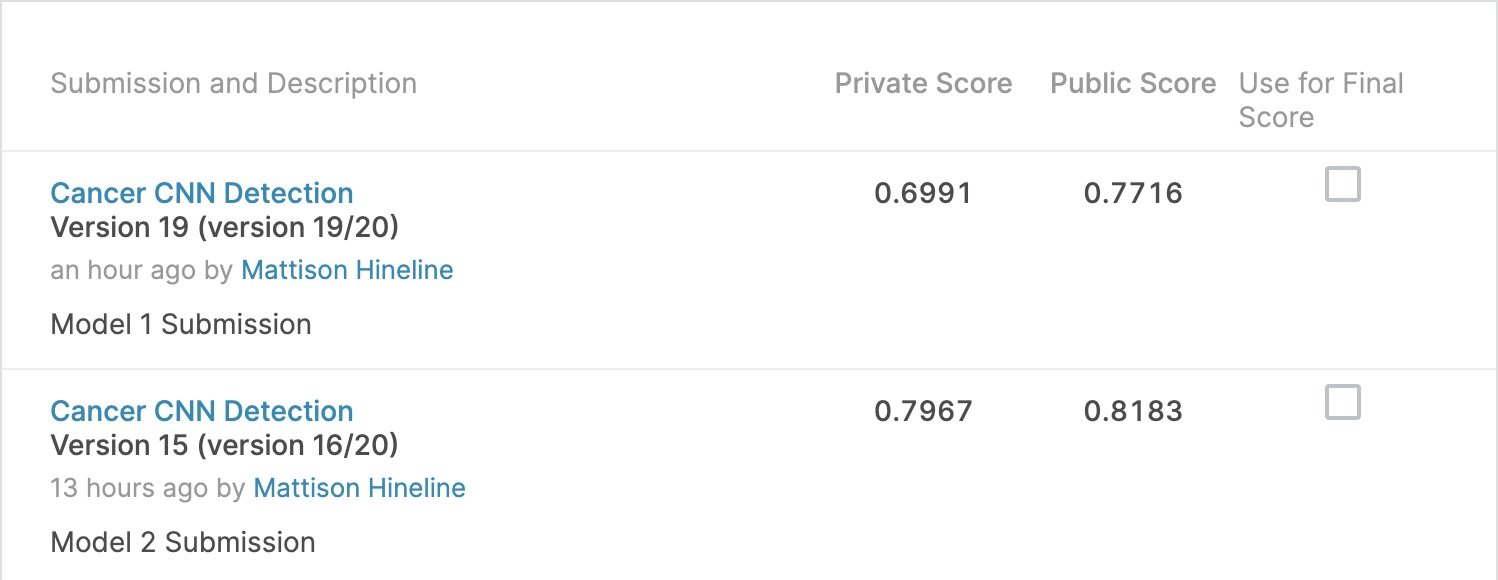

### 5. Conclusion

Our first model was simple with no hyperparameter tuning. The second model incorporated much more tuning and a few extra layers. Both models trained for 10 epochs and performed resonably well given that they both are fairly simple. As expected, the second model did better than the first. We can see that hyperparameter tuning does indeed contribute to the model performance and can improve the model if done correctly. 

Some ways to make the models better could be a variety of factors. First, I would suggest to train the model with augmented images. In the preprocessing step, we only normalized the images. Instead, you could normalize, flip, zoom  in/out, stretch, rotate, etc. with the images so that the model learns more instances of how images can be shaped. However, this was not done in this notebook due to time and memory constraints. In addition to image augmentation, using more epochs could allow the model to learn better. However, it is important that we don't overfit the data by training it too long. Since this project is for demonstration purposes, we did not use more epochs either. Some other ideas to make a stronger model would be to (1) transfer learning where part of the model is taken from another well-trained model, (2) tune hyperparameters in different ways such as strides, filter size, activation functions, learning rate, etc, and (3) have more complex model with more layers. It is hard to say which modification to the notebook and/or model would return in much better results without actually doing it and running the models however, we are confident that these are good steps to try in another notebook.